# Case Study 6 - Environmental Correlation for Productivity
## Description 
Analyse relationship between different environmental drivers and plant yield. This study demonstrates: 1) Loading heterogeneous data sources into a cube, and 2) Analysis and visualisation of drivers.
This study combines a suite of spatial variables at different scales across multiple sites to analyse the factors correlated with a variable of interest.
A comparable case is the iMapPests data for the same pest across multiple sites and locations to analyse the relationship between population levels and environmental context at the time and over the previous month, including weather (temperature, rainfall, humidity - all xyt), lunar phase (t) and greenness (xyt - see https://portal.tern.org.au/metadata/TERN/8542d90e-6e20-4ad8-b30d-0a171b61d3f5).


## Data Sources
The dataset includes the Gilbert site in Queensland which has multiple standard sized plots for three years. We are using data from 2022.

1. Boundary file - This is a shapefile defining the boundaries of all field plots at the Gilbert site. Each polygon represents a single plot and is associated with a unique Plot ID (e.g., 03_03_1).
These plot IDs are essential for joining and aligning data across the orthomosaics and plot-level measurements.
2. Orthomosaics - The site was imaged by UAV flights multiple times throughout the 2022 growing season, spanning from June to October.
Each flight produced an orthorectified mosaic image using RGB and Multispectral (MS) sensors.
3. Plot level measurements - Multispectral Traits: Calculated from MS sensor imagery and include indices NDVI, NDRE, SAVI and Biomass Cuts: Field-measured biomass sampled during different growth stages (used as a proxy for yield).

## Dependencies

- This notebook requires Python 3.10 or higher  
- Install relevant Python libraries with: pip install mccn-engine rocrate
- Installing mccn-engine will install other dependencies

## DataCube Generation


### Loading raw data using the MCCN Engine

In [82]:
from concurrent.futures import ProcessPoolExecutor
from stac_generator.factory import StacGeneratorFactory
from stac_generator.core import StacCollectionConfig , StacSerialiser
from pathlib import Path 

parent_path = Path().cwd()
configs = [
    parent_path / "source_data/multispec_shape_config.json",
    parent_path / "source_data/raster_config.json",
    parent_path / "source_data/biomass_shape_config.json",
    parent_path/ "source_data/plots_config.json"
]
output_path = parent_path / "generated_stac"
collection_config = StacCollectionConfig(id="Collection")

# Serialising STAC records
with ProcessPoolExecutor(max_workers=8) as pool:
    generator = StacGeneratorFactory.get_collection_generator(source_configs=configs, collection_config=collection_config, pool=pool)
    serialiser = StacSerialiser(generator, output_path.as_posix())
    serialiser() 

2025-05-28T15:53:41-stac_generator.core.vector.generator - INFO - Reading vector asset: multispec_gilbert_2022
2025-05-28T15:53:41-stac_generator.core.raster.generator - INFO - Reading raster asset: gilbert_ms_late
2025-05-28T15:53:41-stac_generator.core.vector.generator - INFO - Reading vector asset: Plots
2025-05-28T15:53:41-stac_generator.core.raster.generator - INFO - Reading raster asset: gilbert_ms_mid
2025-05-28T15:53:41-stac_generator.core.raster.generator - INFO - Reading raster asset: gilbert_ms_early
2025-05-28T15:53:41-stac_generator.core.vector.generator - INFO - Reading vector asset: biomass_gilbert_2022
2025-05-28T15:53:41-stac_generator.core.vector.generator - INFO - Reading join asset for vector asset: multispec_gilbert_2022
2025-05-28T15:53:41-stac_generator.core.vector.generator - INFO - Reading join asset for vector asset: biomass_gilbert_2022
2025-05-28T15:53:42-stac_generator.core.base.generator - INFO - successfully save collection Collection to /Users/a1234648/m

In [83]:
# Loading in data cube 
from mccn.client import MCCN 

client = MCCN(endpoint = output_path/"collection.json", shape=(100, 100))
raw_ds = client.load()

In [84]:
raw_ds

<xarray.Dataset> Size: 25MB
Dimensions:                 (time: 27, y: 100, x: 100)
Coordinates:
  * y                       (y) float64 800B -27.56 -27.56 ... -27.57 -27.57
  * x                       (x) float64 800B 152.3 152.3 152.3 ... 152.3 152.3
    spatial_ref             int32 4B 4326
  * time                    (time) datetime64[ns] 216B 2022-06-29T14:00:00 .....
Data variables: (12/15)
    blue                    (time, y, x) float64 2MB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    green                   (time, y, x) float64 2MB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    mask                    (time, y, x) float64 2MB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    nir                     (time, y, x) float64 2MB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    red                     (time, y, x) float64 2MB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    red_edge                (time, y, x) float64 2MB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    ...                      ...
    median_ndre_r           (time, y, x) float64 2MB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    median_ndvi             (time, y, x) float64 2MB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    median_savi             (time, y, x) float64 2MB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    biomass_gilbert_2022    (time, y, x) int8 270kB 0 0 0 0 0 0 ... 0 0 0 0 0 0
    main_fw                 (time, y, x) float64 2MB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    Plots                   (time, y, x) int8 270kB 0 0 0 0 0 0 ... 0 0 0 0 0 0
Attributes:
    multispec_gilbert_2022:  {0: 'nodata', 1: 'multispec_gilbert_2022'}
    plot_id:                 {0: 'nodata', 1: '03_03', 2: '04_03', 3: '05_03'...
    biomass_gilbert_2022:    {0: 'nodata', 1: 'biomass_gilbert_2022'}
    Plots:                   {0: 'nodata', 1: 'Plots'}

## Data Manipulation

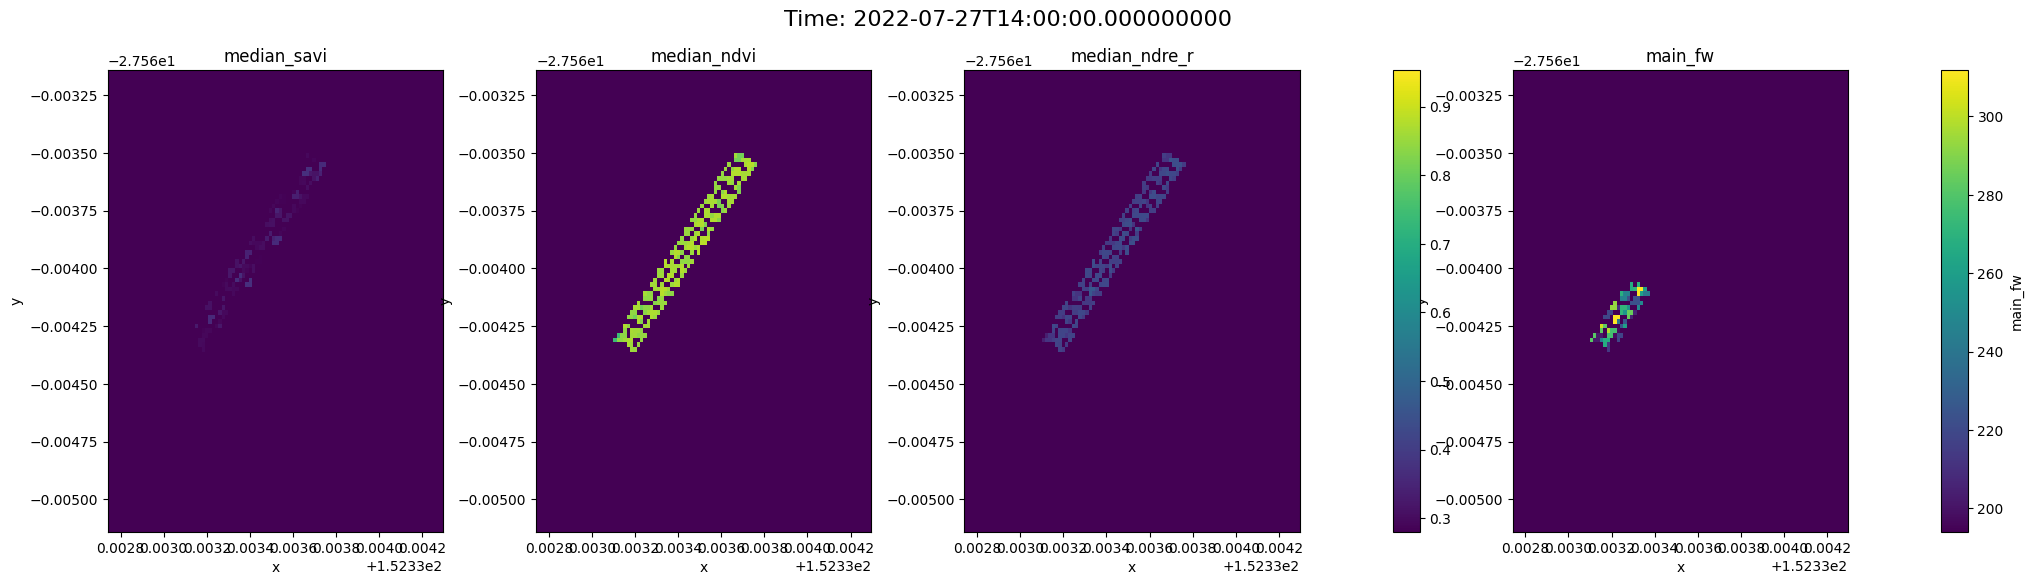

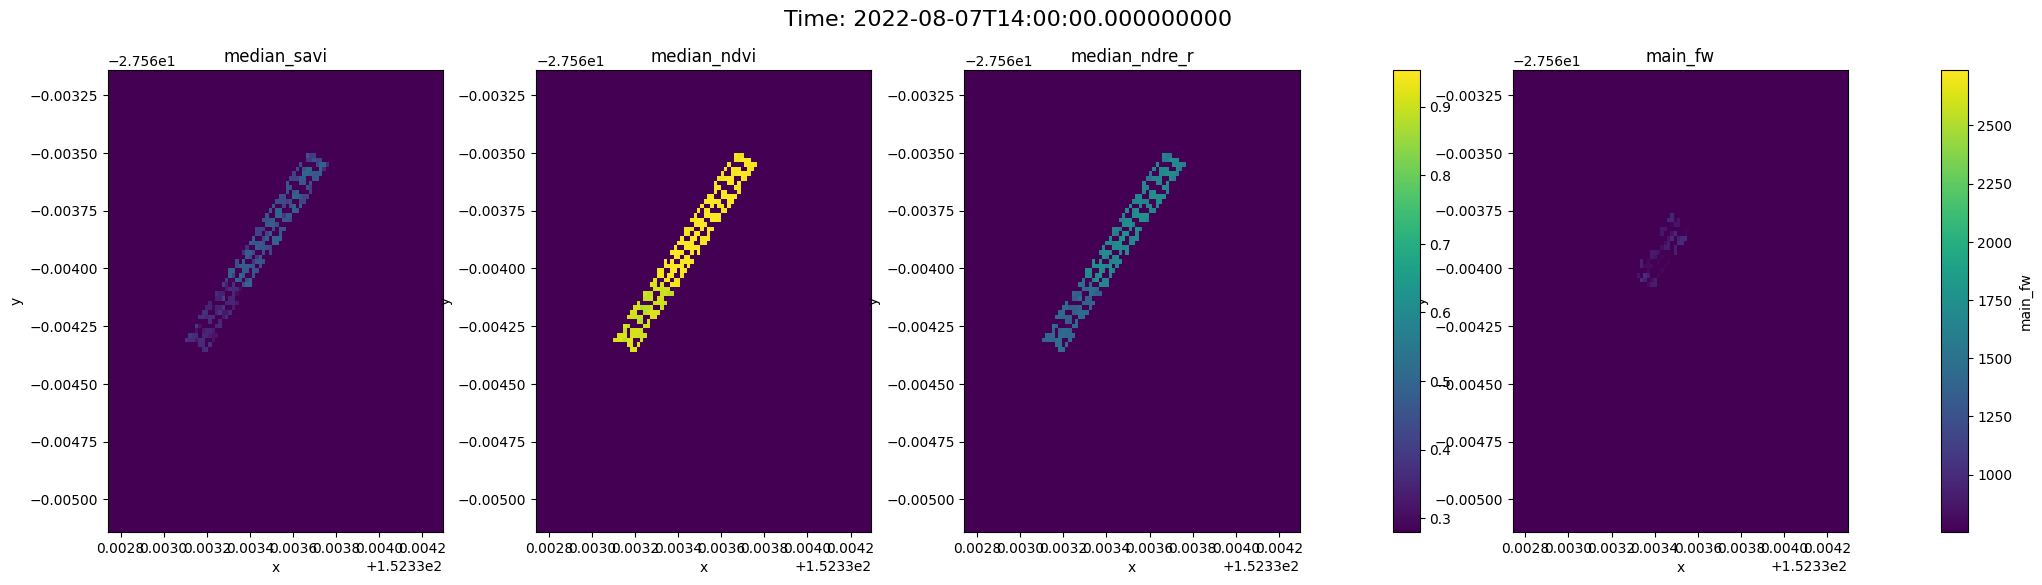

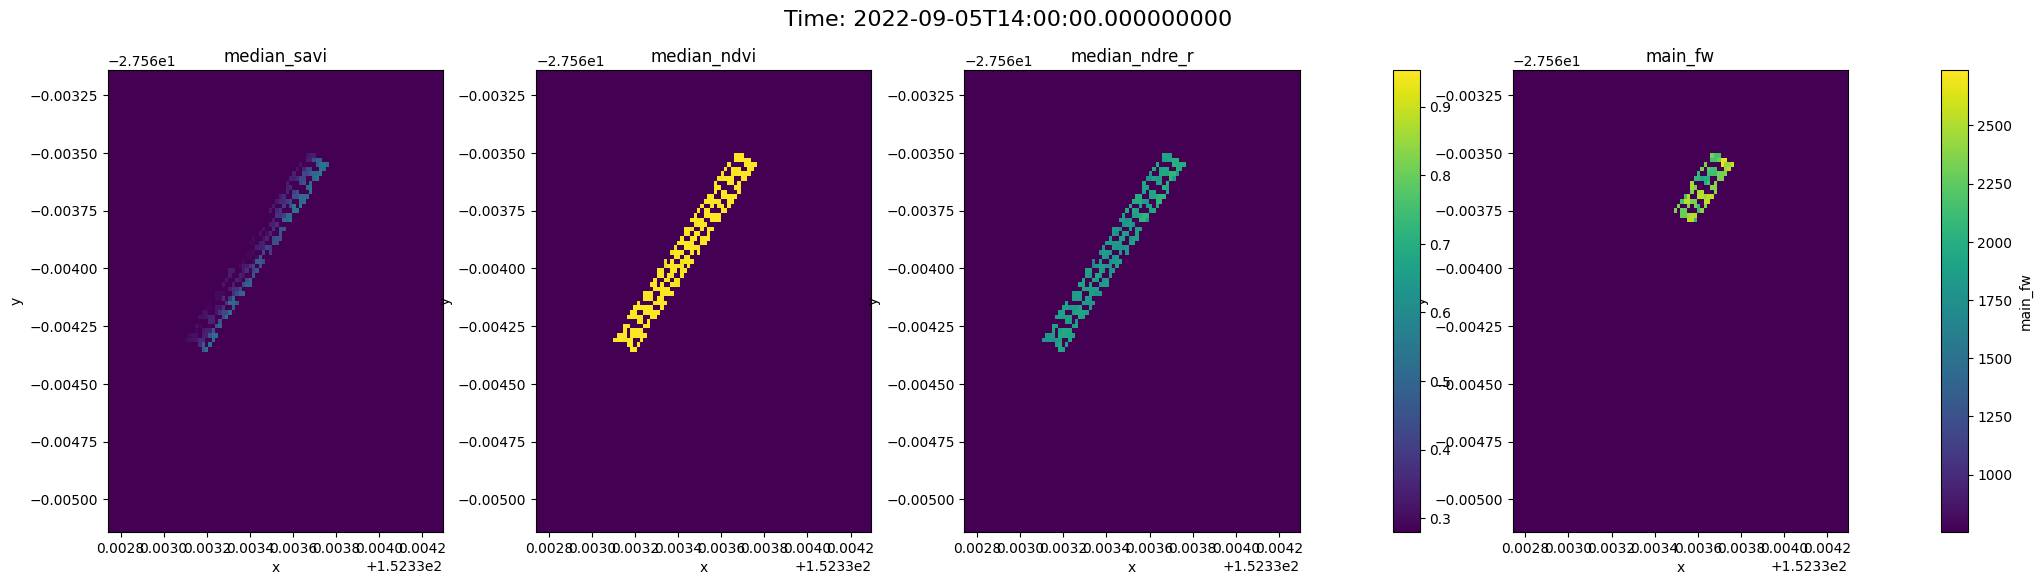

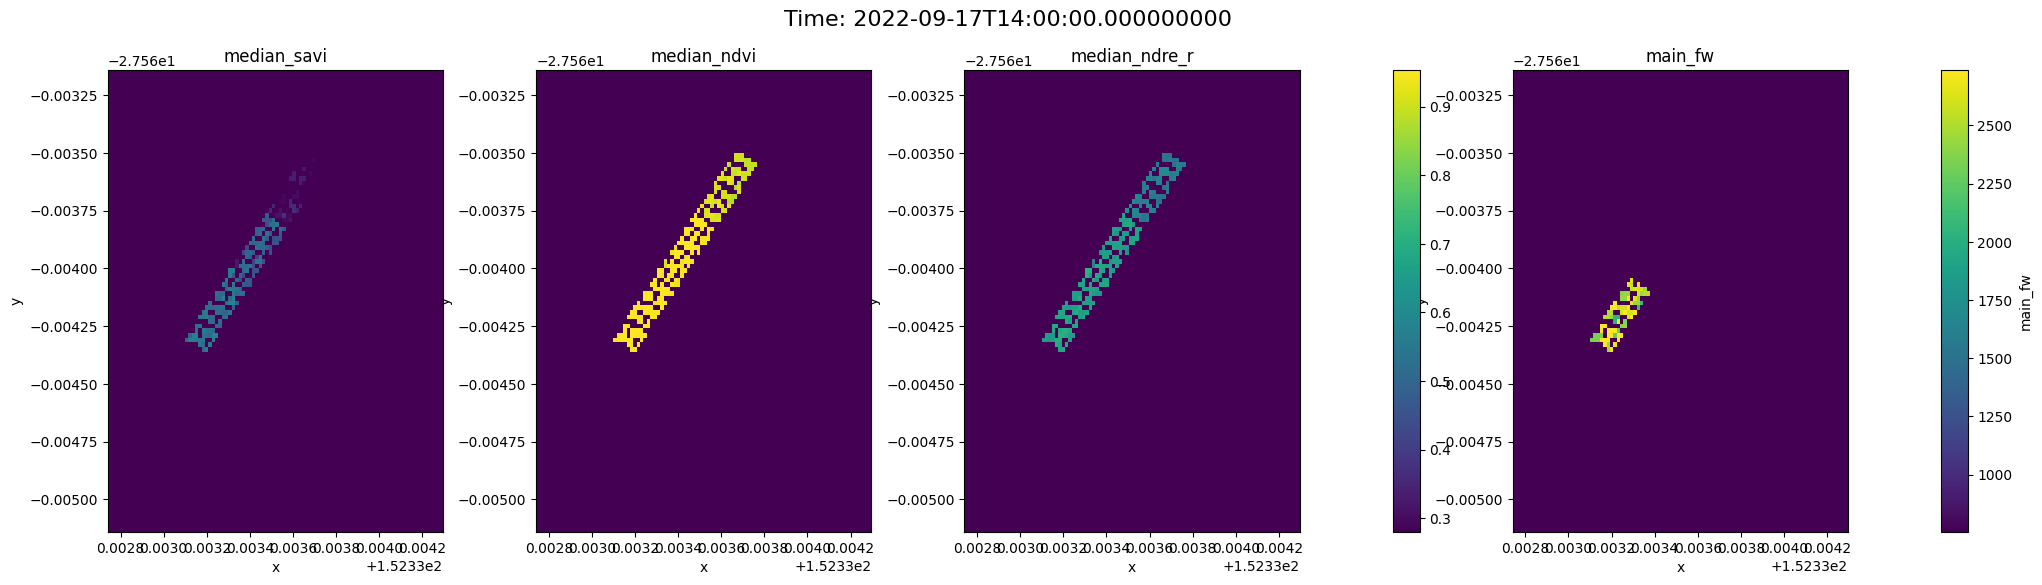

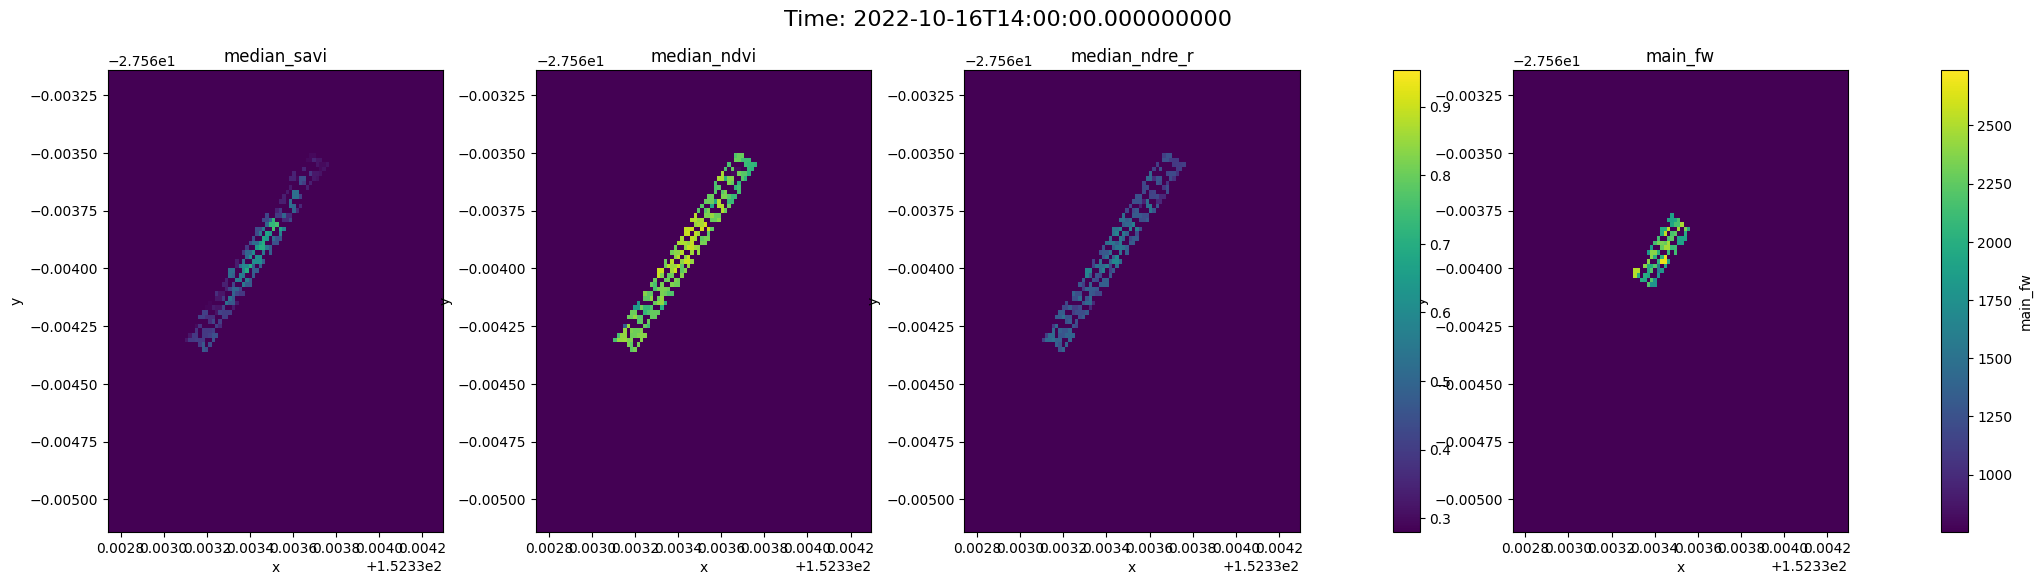

In [85]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize
import matplotlib.cm as cm

keep_timepoints = [1, 5, 9, 15, 16, 18, 23, 24]
remap_biomass = {16: 15, 24: 23}

ds_subset = raw_ds.isel(time=keep_timepoints)

# Remap biomass data
for src, dest in remap_biomass.items():
    src_i = keep_timepoints.index(src)
    dest_i = keep_timepoints.index(dest)
    ds_subset["main_fw"][dest_i] = ds_subset["main_fw"][src_i]

final_time_indices = [1, 2, 3, 5, 6]
ds_final = ds_subset.isel(time=final_time_indices)
ds_final = ds_final[["median_ndvi", "median_ndre_r", "median_savi", "main_fw"]]

# Calculate fixed scales
vegetation_indices = ["median_savi", "median_ndvi", "median_ndre_r"]

# Fixed scale for vegetation indices (across all time steps)
veg_data_combined = []
for var in vegetation_indices:
    veg_data_combined.append(ds_final[var].where(ds_final[var] > 0))

veg_all = xr.concat(veg_data_combined, dim='variable')
veg_vmin = max(0.001, veg_all.quantile(0.05).values)
veg_vmax = veg_all.quantile(0.95).values

# Fixed scale for main_fw (excluding first time step which has low values)
fw_data = ds_final["main_fw"].isel(time=slice(1, None)).where(ds_final["main_fw"].isel(time=slice(1, None)) > 0)
fw_vmin = max(0.001, fw_data.quantile(0.05).values)
fw_vmax = fw_data.quantile(0.95).values

# Separate scale for first time step main_fw
fw_first_data = ds_final["main_fw"].isel(time=0).where(ds_final["main_fw"].isel(time=0) > 0)
if (~np.isnan(fw_first_data)).sum() > 0:
    fw_first_vmin = max(0.001, fw_first_data.quantile(0.05).values)
    fw_first_vmax = fw_first_data.quantile(0.95).values
else:
    fw_first_vmin, fw_first_vmax = fw_vmin, fw_vmax

variables = ["median_savi", "median_ndvi", "median_ndre_r", "main_fw"]

for i in range(ds_final.sizes["time"]):
    time_val = ds_final.time.values[i]
    
    # Create figure with extra space for colorbars
    fig = plt.figure(figsize=(24, 6))
    
    # Create main subplot area with space for two colorbars
    gs = fig.add_gridspec(1, 6, width_ratios=[1, 1, 1, 0.08, 1, 0.08], wspace=0.4)
    
    # Create subplots for each variable
    axes = []
    axes.append(fig.add_subplot(gs[0, 0]))  # median_savi
    axes.append(fig.add_subplot(gs[0, 1]))  # median_ndvi  
    axes.append(fig.add_subplot(gs[0, 2]))  # median_ndre_r
    axes.append(fig.add_subplot(gs[0, 4]))  # main_fw
    
    # Create colorbar axes
    veg_cbar_ax = fig.add_subplot(gs[0, 3])
    fw_cbar_ax = fig.add_subplot(gs[0, 5])
    
    fig.suptitle(f'Time: {time_val}', fontsize=16)
    
    veg_im = None
    fw_im = None
    
    for j, var in enumerate(variables):
        data = ds_final.isel(time=i)[var]
        
        if var in vegetation_indices:
            vmin, vmax = veg_vmin, veg_vmax
            im = data.plot(
                ax=axes[j],
                x="x",
                vmin=vmin,
                vmax=vmax,
                cmap='viridis',
                add_colorbar=False
            )
            if veg_im is None:
                veg_im = im
        else:  # main_fw
            if i == 0:  # First time step gets its own scale
                vmin, vmax = fw_first_vmin, fw_first_vmax
            else:  # Other time steps use the common scale
                vmin, vmax = fw_vmin, fw_vmax
            
            im = data.plot(
                ax=axes[j],
                x="x",
                vmin=vmin,
                vmax=vmax,
                cmap='viridis',
                add_colorbar=False
            )
            fw_im = im
        
        axes[j].set_title(f'{var}')
    
    # common colorbar for vegetation indices
    if veg_im is not None:
        norm = Normalize(vmin=veg_vmin, vmax=veg_vmax)
        sm = cm.ScalarMappable(norm=norm, cmap='viridis')
        sm.set_array([])
        cbar_veg = plt.colorbar(sm, cax=veg_cbar_ax)
    
    # colorbar for main_fw
    if fw_im is not None:
        if i == 0:
            norm_fw = Normalize(vmin=fw_first_vmin, vmax=fw_first_vmax)
        else:
            norm_fw = Normalize(vmin=fw_vmin, vmax=fw_vmax)
        sm_fw = cm.ScalarMappable(norm=norm_fw, cmap='viridis')
        sm_fw.set_array([])
        cbar_fw = plt.colorbar(sm_fw, cax=fw_cbar_ax)
        cbar_fw.set_label('main_fw')
            
    plt.subplots_adjust()
    plt.show()

In [86]:
ds_final

<xarray.Dataset> Size: 2MB
Dimensions:        (time: 5, y: 100, x: 100)
Coordinates:
  * y              (y) float64 800B -27.56 -27.56 -27.56 ... -27.57 -27.57
  * x              (x) float64 800B 152.3 152.3 152.3 ... 152.3 152.3 152.3
    spatial_ref    int32 4B 4326
  * time           (time) datetime64[ns] 40B 2022-07-27T14:00:00 ... 2022-10-...
Data variables:
    median_ndvi    (time, y, x) float64 400kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    median_ndre_r  (time, y, x) float64 400kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    median_savi    (time, y, x) float64 400kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    main_fw        (time, y, x) float64 400kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes:
    multispec_gilbert_2022:  {0: 'nodata', 1: 'multispec_gilbert_2022'}
    plot_id:                 {0: 'nodata', 1: '03_03', 2: '04_03', 3: '05_03'...
    biomass_gilbert_2022:    {0: 'nodata', 1: 'biomass_gilbert_2022'}
    Plots:                   {0: 'nodata', 1: 'Plots'}

In [87]:
df_masked = ds_final.to_dataframe().reset_index()
df_masked_clean = df_masked[df_masked["main_fw"] > 0]
df_masked_clean.head()

,time,y,x,median_ndvi,median_ndre_r,median_savi,main_fw,spatial_ref
4535,2022-07-27 14:00:00,-27.56405,152.333293,0.856775,0.409613,0.287078,193.99,4326
4634,2022-07-27 14:00:00,-27.56407,152.333278,0.856775,0.409613,0.287078,193.99,4326
4635,2022-07-27 14:00:00,-27.56407,152.333293,0.859726,0.413170,0.298277,267.06,4326
4637,2022-07-27 14:00:00,-27.56407,152.333324,0.859783,0.406242,0.299752,270.40,4326
4735,2022-07-27 14:00:00,-27.56409,152.333293,0.859726,0.413170,0.298277,267.06,4326


## Data Analysis and Correlation

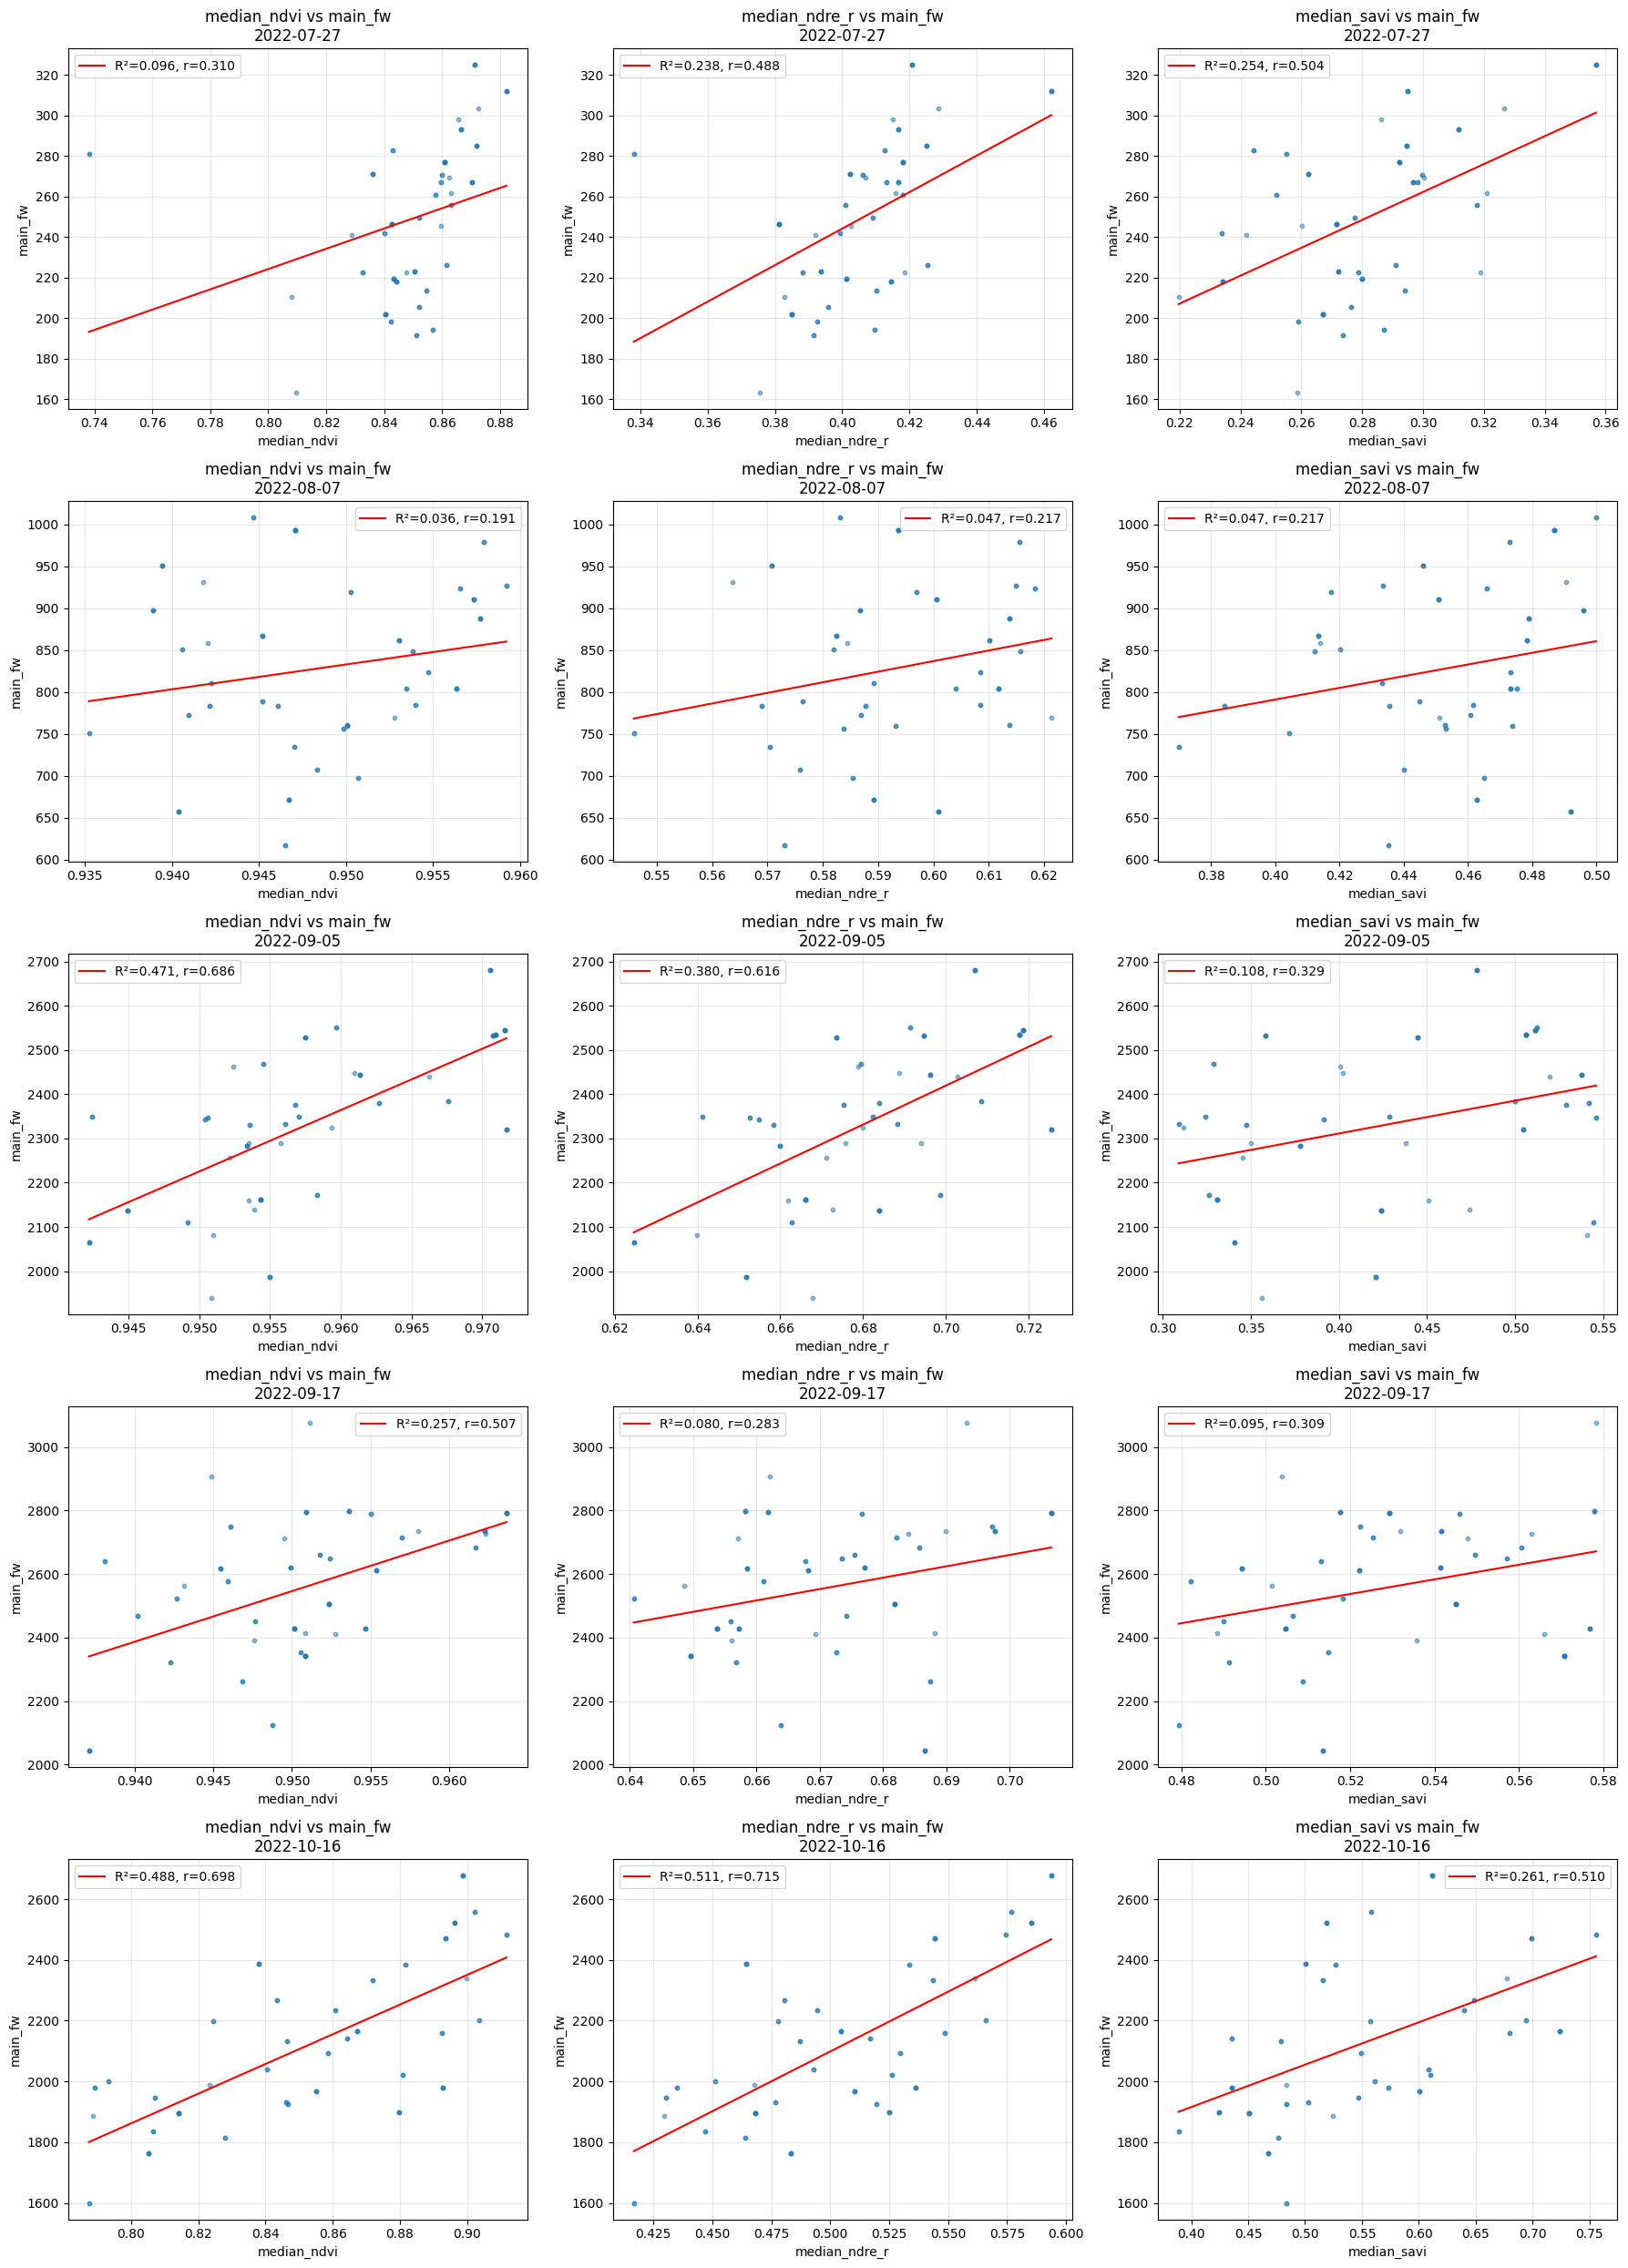

In [91]:
import matplotlib.pyplot as plt
import numpy as np

indices = ["median_ndvi", "median_ndre_r", "median_savi"]
fw_var = "main_fw"

fig, axes = plt.subplots(5, 3, figsize=(18, 25))
axes = axes.flatten()

timepoints = df_masked_clean['time'].unique()
stats_output = []

for time_idx, current_time in enumerate(timepoints):
    time_data = df_masked_clean[df_masked_clean['time'] == current_time]
    
    for idx, index_var in enumerate(indices):
        ax = axes[time_idx * 3 + idx]

        x = time_data[index_var].values
        y = time_data[fw_var].values

        if len(x) == 0 or np.all(np.isnan(x)) or np.all(np.isnan(y)):
            continue

        ax.scatter(x, y, alpha=0.5, s=10)

        A = np.vstack([x, np.ones(len(x))]).T
        slope, intercept = np.linalg.lstsq(A, y, rcond=None)[0]
        y_pred = slope * x + intercept

        # Compute R²
        ss_res = np.sum((y - y_pred) ** 2)
        ss_tot = np.sum((y - np.mean(y)) ** 2)
        r_squared = 1 - ss_res / ss_tot if ss_tot != 0 else np.nan

        # Compute Pearson correlation (r)
        corr_matrix = np.corrcoef(x, y)
        r = corr_matrix[0, 1]

        stats_output.append({
            "time": str(current_time)[:10],
            "index": index_var,
            "r_squared": r_squared,
            "correlation_r": r
        })

        # Plot regression line
        x_line = np.array([np.nanmin(x), np.nanmax(x)])
        y_line = slope * x_line + intercept
        ax.plot(x_line, y_line, 'r', label=f'R²={r_squared:.3f}, r={r:.3f}')

        ax.set_xlabel(index_var)
        ax.set_ylabel(fw_var)
        ax.set_title(f'{index_var} vs {fw_var}\n{str(current_time)[:10]}')
        ax.legend()
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [89]:
import shutil 
from pathlib import Path
import pandas as pd
from rocrate.rocrate import ROCrate
from rocrate.model import ComputationalWorkflow, SoftwareApplication, File, Dataset, ContextEntity, Person
from mccn.client import MCCN

# Define paths/notebook
notebook = "MCCN-CASE 6.ipynb"
ro_crate = "MCCN-CASE-6.RO-Crate.zip"
result_path = Path("result")
result_path.mkdir(exist_ok=True)

# Inputs
source_path = Path("source_data")
biomass_source = (source_path / "biomass_shape_config.json").as_posix()
multispec_source = (source_path / "multispec_shape_config.json").as_posix()
plots_source = (source_path / "plots_config.json").as_posix()
raster_source = (source_path / "raster_config.json").as_posix()

# Save datacubes
raw_path = result_path / "datacube_initial.nc"
proc_path = result_path / "datacube_final.nc"
stats_path = result_path / "stats.csv"
MCCN.to_netcdf(raw_ds, raw_path)
MCCN.to_netcdf(ds_final, proc_path)
pd.DataFrame(data=stats_output).to_csv(stats_path)

# Create crate
crate = ROCrate()

# Organisations and people
ardc = crate.add(ContextEntity(crate, "https://ror.org/038sjwq14", properties={
    "@type": "Organisation",
    "name": "Australian Research Data Commons"
}))
appn = crate.add(ContextEntity(crate, "https://ror.org/02zj7b759", properties={
    "@type": "Organisation",
    "name": "Australian Plant Phenomics Network"
}))
dgh = crate.add(Person(crate, "https://orcid.org/0000-0001-6492-4016", properties={
    "name": "Donald Hobern",
    "email": "donald.hobern@adelaide.edu.au",
    "affiliation": {"@id": appn.id},
    "jobTitle": "APPN Data Management Director",
}))
aa = crate.add(Person(crate, "https://github.com/alisha17", properties={
    "name": "Alisha Aneja",
    "affiliation": {"@id": appn.id},
    "jobTitle": "APPN Senior Software Engineer",
}))

# Project & license
food_security = crate.add(ContextEntity(crate, "https://doi.org/10.47486/DC105", properties={
    "@type": "Grant",
    "name": "ARDC Project Code DC105: Multi-Scalar Crop Characterisation Network (MCCN)",
    "funder": {"@id": ardc.id}
}))
mccn = crate.add(ContextEntity(crate, "https://doi.org/10.26292/8679d473", properties={
    "@type": "ResearchProject",
    "name": "Multi-Scalar Crop Characterisation Network (MCCN)",
    "funding": {"@id": food_security.id},
    "contactPoint": {"@id": dgh.id},
}))
cc_by = crate.add(ContextEntity(crate, "https://creativecommons.org/licenses/by/4.0/", properties={
    "@type": "License",
    "name": "Creative Commons Attribution 4.0 International (CC BY 4.0)",
}))

# Crate metadata
crate.default_entities[0].properties() == {
    "name": "MCCN Case Study 6 - Environmental Correlation of Productivity",
    "description": "RO-Crate packaging for Case Study 6 exploring spatial indices vs biomass using xarray and matplotlib.",
    "license": {"@id": cc_by.id},
    "maintainer": {"@id": mccn.id},
}

# Output datasets
cube1 = crate.add(File(crate, source=raw_path, dest_path=raw_path, properties={
    "name": "Initial datacube before processing",
    "license": {"@id": cc_by.id},
    "encodingFormat": "application/x-netcdf",
    "producer": {"@id": appn.id},
}))
cube2 = crate.add(File(crate, source=proc_path, dest_path=proc_path, properties={
    "name": "Processed datacube after biomass filtering",
    "license": {"@id": cc_by.id},
    "encodingFormat": "application/x-netcdf",
    "producer": {"@id": appn.id},
}))

# Software
mccn_engine = crate.add(SoftwareApplication(crate, "https://github.com/aus-plant-phenomics-network/mccn-engine", properties={
    "name": "MCCN-Engine",
    "description": "Python library for STAC-described datacube loading.",
    "maintainer": {"@id": mccn.id},
}))
stac_generator = crate.add(SoftwareApplication(crate, "https://github.com/aus-plant-phenomics-network/stac-generator", properties={
    "name": "STAC Generator",
    "description": "Tool for generating STAC-compliant metadata records.",
    "maintainer": {"@id": mccn.id},
}))

# Notebook as workflow
crate.add(ComputationalWorkflow(crate, source=notebook, dest_path=notebook, properties={
    "name": "MCCN Case Study 6 Notebook: Environmental Correlation Analysis",
    "encodingFormat": "application/x-ipynb+json",
    "creator": {"@id": aa.id},
    "maintainer": {"@id": mccn.id},
    "license": {"@id": cc_by.id},
    "softwareRequirements": [
        {"@id": mccn_engine.id},
        {"@id": stac_generator.id},
    ],
    "input": [
        { "@id": biomass_source.id},
        { "@id": multispec_source.id},
        { "@id": plots_source.id},
        { "@id": raster_source.id}  
    ],
    "output": [
        { "@id": raw_path.id},
        { "@id": proc_path.id},
        { "@id": stats_path.id}
    ],
}))

# Write crate
crate.write_zip(ro_crate)

# Optionally clean up
shutil.rmtree("generated_stac")
